## Подготовка данных

Импортируем все нужные нам инструменты и посмотрим на данные

In [162]:
!pip install scikit-learn --upgrade
!pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0.1)
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: imbalanced-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.8.1)


In [163]:
import imblearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [164]:
raw_df = pd.read_csv('/datasets/Churn.csv')
df = raw_df.copy()

In [165]:
df.isna().mean().apply('{:.2%}'.format)

RowNumber          0.00%
CustomerId         0.00%
Surname            0.00%
CreditScore        0.00%
Geography          0.00%
Gender             0.00%
Age                0.00%
Tenure             9.09%
Balance            0.00%
NumOfProducts      0.00%
HasCrCard          0.00%
IsActiveMember     0.00%
EstimatedSalary    0.00%
Exited             0.00%
dtype: object

Видим 9% пропущенных значений в колонке Tenure - сколько лет человек является клиентом банка

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видим три колонки со строковыми значениями

In [167]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000,NaN,NaN,NaN,5000.5,2886.9,1,2500.75,5000.5,7500.25,10000
CustomerId,10000,NaN,NaN,NaN,1.56909e+07,71936.2,1.55657e+07,1.56285e+07,1.56907e+07,1.57532e+07,1.58157e+07
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000,NaN,NaN,NaN,650.529,96.6533,350,584,652,718,850
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000,NaN,NaN,NaN,38.9218,10.4878,18,32,37,44,92
Tenure,9091,NaN,NaN,NaN,4.99769,2.89472,0,2,5,7,10
Balance,10000,NaN,NaN,NaN,76485.9,62397.4,0,0,97198.5,127644,250898
NumOfProducts,10000,NaN,NaN,NaN,1.5302,0.581654,1,1,1,2,4


In [168]:
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9636,9637,15613048,Anderson,648,Germany,Female,40,5.0,139973.65,1,1,1,667.66,1
3794,3795,15621409,Endrizzi,496,France,Male,32,4.0,127845.83,1,1,0,66469.20,0
8267,8268,15798737,Chao,654,France,Male,38,NaN,0.00,2,1,0,88659.44,0
6522,6523,15632185,Yermolayev,663,France,Female,42,1.0,82228.67,2,1,0,71359.78,0
9541,9542,15669290,Fan,603,France,Male,38,8.0,59360.77,1,1,1,191457.06,0


Чтобы избавиться от пропущенных значений, посмотрим на медианные и средние значения Tenure для каждого из значений Exited

In [169]:
print(df.query('Exited == 0')['Tenure'].median())
print(df.query('Exited == 0')['Tenure'].mean())

5.0
5.022246787342822


In [170]:
print(df.query('Exited == 1')['Tenure'].median())
print(df.query('Exited == 1')['Tenure'].mean())

5.0
4.901833872707659


Заменим все пропущенные значения на 5.

In [171]:
df['Tenure'] = df['Tenure'].fillna(5)

Посмотрим на уникальные значения в колонках Gender и Geography

In [172]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [173]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Значений немного, для использования в качестве входных данных для моделей преобразуем значений в этих колонках c помощью OHE на следующем шаге внутри конвейера. Но сначала избавимся от колонок *Surname, Row_number и CustomerId*, поскольку они не содержат полезной для обучения модели информации

In [174]:
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

## Исследование задачи

Разделим данные и посмотрим на баланс классов в задаче

In [175]:
X = df.drop(['Exited'], axis=1)
y= df['Exited']

In [176]:
y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

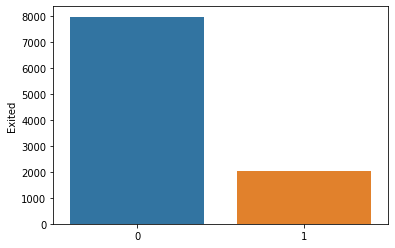

In [177]:
sns.barplot(x=[0, 1], y=y.value_counts())
plt.show()

**Число объектов класса 1 почти в 4 раза меньше чем число объектов класса 0**

Для решения задачи создадим несколько пайплайнов с различными моделями. На данном этапе дисбаланс классов учитывать не будем.

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

numeric_features = X.select_dtypes(exclude='object').columns
categorical_features = X.select_dtypes(include='object').columns

Нам необходимо преобразовать категориальные признаки и затем стандартизировать все признаки.

In [179]:
numeric_transformer = StandardScaler()

cat_transformer_std = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='error')),
    ('scaler', StandardScaler(with_mean=False))
])


preprocessor = ColumnTransformer(transformers=[
    ('num_transform', numeric_transformer, numeric_features),
    ('cat_transform', cat_transformer_std, categorical_features)
])

Указываем гиперпараметры логистической регрессии которые будем перебирать

In [180]:
param_grid_lr = [
    {
        'penalty':['l1','l2'],
        'C': np.logspace(-2, 2, 20),
    }
]

In [181]:
lr_classifier = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42), param_grid_lr, scoring='f1', cv=5)

И создаем пайплайн, включающий в себя предобработку признаков, а так же обучение и поиск наилучших гиперпараметров для логистической регрессии

In [182]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr_classifier)])

Для двух других классификаторов создадим свой предобработчик без стандартизации

In [183]:
categorical_transformer_ohe  = OneHotEncoder(drop='first', handle_unknown='error')
preprocessor_ohe = ColumnTransformer(transformers=[
    ('num_transform', numeric_transformer, numeric_features),
    ('cat_transform', categorical_transformer_ohe, categorical_features)
])

Аналогично указываем перебираемые гиперпараметры для дерева решений

In [184]:
param_grid_dt = [
    {
        'max_depth': [i for i in range(1, 21, 1)],
        'min_samples_split': [i for i in range(2, 20, 2)],
        'min_samples_leaf': [i for i in range(1,21, 2)]
    }
]

И создаем пайплайн, включающий в себя предобработку признаков, а так же обучение и поиск наилучших гиперпараметров для дерева решений

In [185]:
dt_classifier = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, scoring='f1', cv=5)

In [186]:
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor_ohe), ('classifier', dt_classifier)])

Указываем перебираемые параметры для случайного леса

In [187]:
param_grid_rf = [
    {
        'max_depth': [i for i in range(1, 30, 5)],
        'min_samples_split': [i for i in range(2, 20, 5)],
        'min_samples_leaf': [2, 4],
    }
]

И создаем пайплайн, включающий в себя предобработку признаков, а так же обучение и поиск наилучших гиперпараметров для случайного леса

In [188]:
rf_classifier = GridSearchCV(RandomForestClassifier(random_state=42, n_estimators=70), param_grid_rf, scoring='f1', cv=5)

In [189]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_ohe), ('classifier', rf_classifier)])

**Напишем небольшую функцию для запуска пайплайнов и оценки результата**

In [190]:
def run_pipelines(pipelines, text_and_score, X_train, y_train, X_test, y_test):
    for idx, value in enumerate(text_and_score):
        pipelines[idx].fit(X_train, y_train)
        pred = pipelines[idx].predict(X_test)
        pred_proba = pipelines[idx].predict_proba(X_test)
        pred_proba = pred_proba[:, 1]
        text_and_score[value][1] = f1_score(y_test, pred)
        text_and_score[value][2] = roc_auc_score(y_test, pred_proba)
        print('Модель:', text_and_score[value][0])
        print('Метрика F1:', text_and_score[value][1])
        print('Метрика ROC_AUC:', text_and_score[value][2], '\n')
        
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривая')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.show()
        
        
    return text_and_score

In [191]:
pipelines = [lr_pipeline, dt_pipeline, rf_pipeline]
results = {0: ['Логистическая регрессия', 0, 0], 1: ['Дерево решений', 0, 0], 2: ['Случайный лес', 0, 0]}

**Мы подготовили пайплайны для трех различных моделей без учета дисбаланса классов**

## Борьба с дисбалансом

Используем те же модели что и выше, но с учетом дисбаланса классов. Добавим к моделям параметр *class_weight='balanced'*

In [192]:
lr_classifier_bal = GridSearchCV(LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42), param_grid_lr, scoring='f1', cv=5)
dt_classifier_bal = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=42), param_grid_dt, scoring='f1', cv=5)
rf_classifier_bal = GridSearchCV(RandomForestClassifier( n_estimators=70, class_weight='balanced', random_state=42), param_grid_rf, scoring='f1', cv=5)
lr_pipeline_bal = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr_classifier_bal)])
dt_pipeline_bal = Pipeline(steps=[('preprocessor', preprocessor_ohe), ('classifier', dt_classifier_bal)])
rf_pipeline_bal = Pipeline(steps=[('preprocessor', preprocessor_ohe), ('classifier', rf_classifier_bal)])

In [193]:
pipelines_bal = [lr_pipeline_bal, dt_pipeline_bal, rf_pipeline_bal]
results_bal = {0: ['Логистическая регрессия с учетом взвешивания классов', 0, 0], 1: ['Дерево решений с учетом взвешивания классов', 0, 0], 2: ['Случайный лес с учетом взвешивания классов', 0, 0]}

Создадим массивы для сохранения результатов метрик при использовании upsample и downsample

In [194]:
lr_pipeline_us = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr_classifier)])
dt_pipeline_us = Pipeline(steps=[('preprocessor', preprocessor_ohe), ('classifier', dt_classifier)])
rf_pipeline_us = Pipeline(steps=[('preprocessor', preprocessor_ohe), ('classifier', rf_classifier)])
lr_pipeline_ds = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lr_classifier)])
dt_pipeline_ds = Pipeline(steps=[('preprocessor', preprocessor_ohe), ('classifier', dt_classifier)])
rf_pipeline_ds = Pipeline(steps=[('preprocessor', preprocessor_ohe), ('classifier', rf_classifier)])

In [195]:
pipelines_us = [lr_pipeline_us, dt_pipeline_us, rf_pipeline_us]
pipelines_ds = [lr_pipeline_ds, dt_pipeline_ds, rf_pipeline_ds]
results_us = {0: ['Логистическая регрессия с использованием upsample', 0, 0], 1: ['Дерево решений с использованием upsample', 0, 0], 2: ['Случайный лес с использованием upsample', 0, 0]}
results_ds = {0: ['Логистическая регрессия с использованием downsample', 0, 0], 1: ['Дерево решений с использованием downsample', 0, 0], 2: ['Случайный лес с использованием downsample', 0, 0]}

**Мы подготовили все необходимые пайплайны с моделями с учетом дисбаланса классов и с различными параметрами.**

## Тестирование модели

Проведем тестирование обученных моделей на тестовых данных.  
Сначала посмотрим на результаты тестирования **моделей без учета дисбаланса классов**

Модель: Логистическая регрессия
Метрика F1: 0.2911764705882353
Метрика ROC_AUC: 0.7741044369060093 



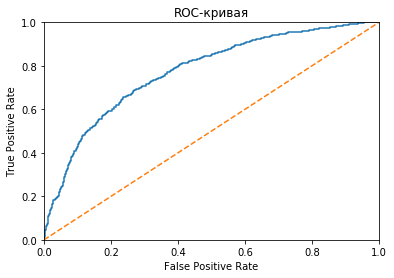

Модель: Дерево решений
Метрика F1: 0.5513784461152882
Метрика ROC_AUC: 0.8403139757165057 



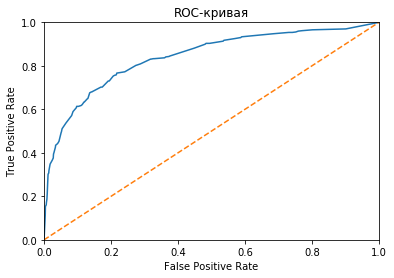

Модель: Случайный лес
Метрика F1: 0.5877957658779578
Метрика ROC_AUC: 0.8611519340707249 



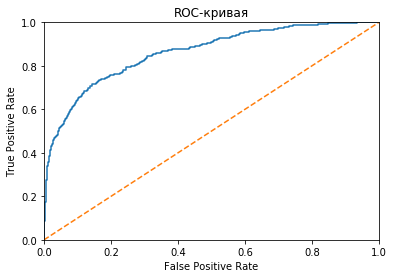

In [196]:
results = run_pipelines(pipelines, results, X_train, y_train, X_test, y_test)

Теперь посмотрим на результаты тестирования **моделей с использованием параметра class_weight='balanced'**

Модель: Логистическая регрессия с учетом взвешивания классов
Метрика F1: 0.49621993127147757
Метрика ROC_AUC: 0.7780552511273332 



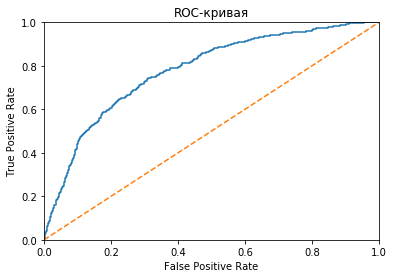

Модель: Дерево решений с учетом взвешивания классов
Метрика F1: 0.5573272589217919
Метрика ROC_AUC: 0.8316187690295542 



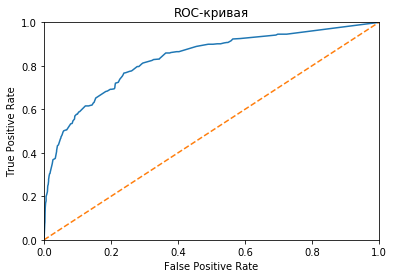

Модель: Случайный лес с учетом взвешивания классов
Метрика F1: 0.6258919469928644
Метрика ROC_AUC: 0.8647853169943274 



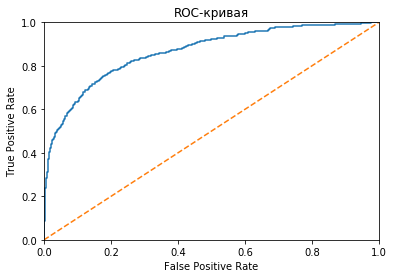

In [197]:
results_bal = run_pipelines(pipelines_bal, results_bal, X_train, y_train, X_test, y_test)

Теперь посмотрим на результаты тестирования **моделей с использованием техники upsample**. Для этого воспользуемся SMOTENC из библиотеки imbalanced learn

In [198]:
smote_nc = SMOTENC(categorical_features=[1, 2], random_state=42)
X_train_us, y_train_us = smote_nc.fit_resample(X_train, y_train)

Модель: Логистическая регрессия с использованием upsample
Метрика F1: 0.47980997624703087
Метрика ROC_AUC: 0.7550304322188748 



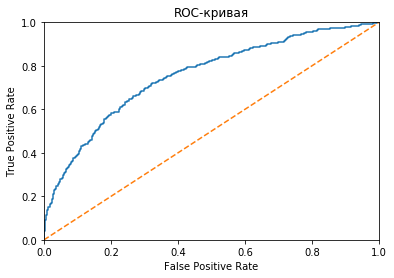

Модель: Дерево решений с использованием upsample
Метрика F1: 0.5721192586623691
Метрика ROC_AUC: 0.8429458428052087 



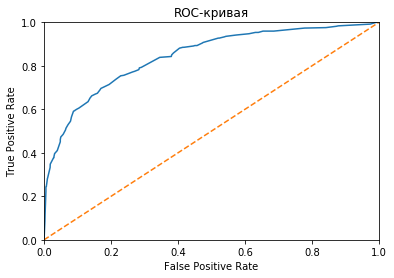

Модель: Случайный лес с использованием upsample
Метрика F1: 0.5936651583710407
Метрика ROC_AUC: 0.8473773243555189 



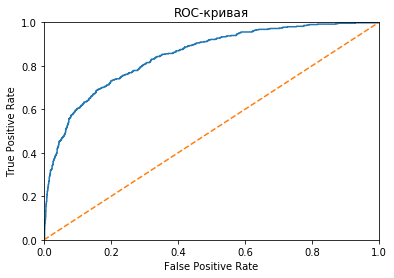

In [199]:
results_us = run_pipelines(pipelines_us, results_us, X_train_us, y_train_us, X_test, y_test)

Теперь посмотрим на результаты тестирования **моделей с использованием техники downsample**. Для этого воспользуемся RandomUnderSampler из библиотеки imbalanced learn

In [200]:
rus = RandomUnderSampler(random_state=42)
X_train_ds, y_train_ds = rus.fit_resample(X_train, y_train)

Модель: Логистическая регрессия с использованием downsample
Метрика F1: 0.5086206896551724
Метрика ROC_AUC: 0.777787041771347 



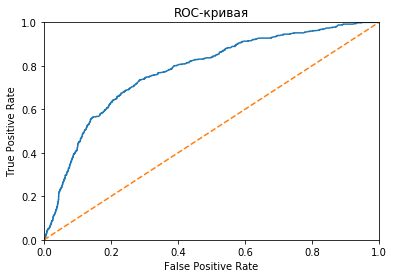

Модель: Дерево решений с использованием downsample
Метрика F1: 0.5625
Метрика ROC_AUC: 0.8319738701806446 



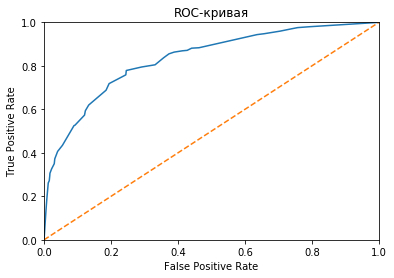

Модель: Случайный лес с использованием downsample
Метрика F1: 0.5985748218527316
Метрика ROC_AUC: 0.8594648269045124 



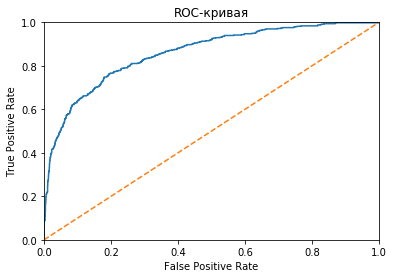

In [201]:
results_ds = run_pipelines(pipelines_ds, results_ds, X_train_ds, y_train_ds, X_test, y_test)

Выведем все результаты в итоговой таблице

In [202]:
result_df = pd.DataFrame(data=[results[0], results_bal[0], results_us[0], results_ds[0], results[1], results_bal[1], results_us[1], results_ds[1], results[2], results_bal[2], results_us[2], results_ds[2]])
result_df.columns = ['Название модели и применяемая техника', 'F1', 'ROC-AUC']
result_df

,Название модели и применяемая техника,F1,ROC-AUC
0,Логистическая регрессия,0.291176,0.774104
1,Логистическая регрессия с учетом взвешивания к...,0.496220,0.778055
2,Логистическая регрессия с использованием upsample,0.479810,0.755030
3,Логистическая регрессия с использованием downs...,0.508621,0.777787
4,Дерево решений,0.551378,0.840314
5,Дерево решений с учетом взвешивания классов,0.557327,0.831619
6,Дерево решений с использованием upsample,0.572119,0.842946
7,Дерево решений с использованием downsample,0.562500,0.831974
8,Случайный лес,0.587796,0.861152
9,Случайный лес с учетом взвешивания классов,0.625892,0.864785


## Общий вывод

Выводы по тестированию моделей:
* Среди моделей без учета дисбаланса классов худшее значение метрики F1 у модели логистической регрессии
* Учитывание дисбаланса классов с помощью параметра class_weight дало наибольший прирост метрики F1 для логистической регрессии
* Практически никакого влияния изменение параметра class_weight не оказало на значение метрики F1 для дерева решений. При этом, при отсутствии изменения метрики F1 для дерева решений мы наблюдаем улучшение значения метрики ROC-AUC
* Применение техники upsample ухудшило значение метрики F1 и ROC-AUC для случайного леса и дерева решений в сравнении с взвешиванием классов, для логистической регрессии только незначительно снизилось значение метрики ROC_AUC
* Применение техники downsample ухудшило значение метрики F1 для случайного леса и дерева решений в сравнении с взвешиванием классов, для этих же моделей значение метрики ROC-AUC не изменилось. Для логистической регрессии незначительно улучшилось значение обеих метрик
* По результатам тестирования лучшей можем считать модель случайного леса с использованием взвешивания классов, со следующими значениями метрик:  
    F1: 0.62  
    ROC-AUC: 0.86